#### GOAL:
Use Bangalore's Customer Counts by sector to get average consumption per customer by sector

#### PROBLEM:
Multiple tariffs by sector. 

#### IMPLEMENTATION:
    1. Group tariffs by sector. 
    2. Convert monthly consumption to annual. 
    3. Get annual consumption by customer by sector, and number of customers by sector. 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


In [2]:
!ls

Financing of Solar Rooftop   Subscriber Count
Policy Overview _ Tariffs    exploring_consumption.ipynb
Polygon Area                 exploring_roofs.ipynb
Prospective Feeder List.xlsx


In [3]:
df = pd.read_excel(os.path.join('Subscriber Count', 'bescom_customers.xlsx'))

In [4]:
df['annual_avg_kwh'] = df['monthly_kwh'] * 12
df['annual_tariff_kwh'] = df['customers'] * df['annual_avg_kwh']
df = df[['sector_abbr','customers','annual_avg_kwh','annual_tariff_kwh']]

In [5]:
# --- group by sector ---
g = df.groupby(['sector_abbr'])[['annual_tariff_kwh','customers']].sum() 
g['mu_kwh'] = g['annual_tariff_kwh'] / g['customers'] #avoid average of averages
g['sector_pct'] = g['annual_tariff_kwh'] / g['annual_tariff_kwh'].sum()

In [6]:
# --- calc weighted std --- 
def weighted_std(values, weights):
    mu = np.average(values, weights=weights)
    variance = np.average((values-mu)**2, weights=weights)
    return math.sqrt(variance)

customer_weighted_std = lambda x: weighted_std(x, weights=df.loc[x.index, 'customers'])
w_stds = df.groupby(['sector_abbr'])['annual_avg_kwh'].agg(customer_weighted_std)
g['sigma_kwh'] = w_stds
g['sigma_pct_load'] = g['sigma_kwh'] / g['mu_kwh']

In [17]:
# --- load number of households from census ---
census = pd.read_csv(os.path.join(os.pardir, 'reference_data','india_census','india_district_pop_2011.csv'))
hh = census.loc[census['district_name'] == 'bangalore','households'].values[0]

g['customers_per_hh'] = g['customers'] / hh

In [18]:
g

,annual_tariff_kwh,customers,mu_kwh,sector_pct,sigma_kwh,sigma_pct_load,customers_per_hh
sector_abbr,,,,,,,
agg,4.001025e+08,9080,44064.155569,0.027112,152852.250582,3.468857,0.003793
com,2.384538e+09,674743,3533.994932,0.161582,5304.220048,1.500913,0.281866
ind,6.712859e+09,7610,882110.302991,0.454881,539450.206531,0.611545,0.003179
res,5.259905e+09,4310647,1220.212378,0.356425,189.689174,0.155456,1.800721


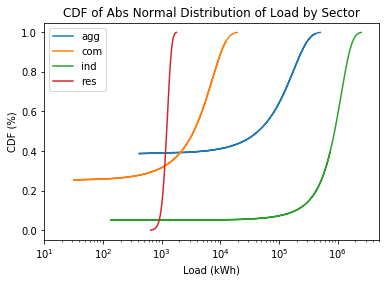

In [8]:
fig, ax = plt.subplots()

for sector, row in g.iterrows():
    mu = row['mu_kwh']
    sigma = row['sigma_kwh']
    
    x = abs(np.linspace(mu - 3*sigma, mu + 3*sigma, 300))
    y = stats.norm.cdf(x, mu, sigma)
    ax.plot(x, y, label=sector)
    
ax.set_title('CDF of Abs Normal Distribution of Load by Sector')
ax.set_xlabel('Load (kWh)')
ax.set_ylabel('CDF (%)')
ax.set_xlim(10,5e6)
ax.set_xscale('log')
ax.legend()

In [ ]:
n_res = 4310647
n_com = 674743
n_ind = 7610